### Seasonal variations in surface temperature: Modeling a Game of Thrones style-planet
Kellie Gadeken, Kassandra Gurule, and Michelle Maclennan   
ATOC 4500 Class Project


### Table of Contents

1. Load Modules   
2. Base Model (Earth)   
    a) Set physical constants, model parameters, latitudinal grid, diffusion, time integration parameters, and initial conditions   
    b) Albedo functions   
    c) Solar forcing functions and contour plot    
    d) Time integration of surface temperature and plots    
3. Experiment: Game of Thrones    
    a) Set physical constants, model parameters, latitudinal grid, diffusion, time integration parameters, and initial conditions (same as in Base Model)   
    b) Albedo functions   
    c) Solar forcing functions and contour plot  
    d) Time integration of surface temperature and plots    
    e) Changes to heat capacity and radius   
    f) More plots    

In [1]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
from   scipy.integrate import solve_ivp
 
%matplotlib inline

### Base Model (Earth)

In [2]:
# Physical constants 
Re     = 6.371E6        # Radius of Earth in m
sigma  = 5.67E-8        # Stephan Boltzmann constant in W / m^2 / K^4
c_s    = 712            # heat capacity of Silicon rock in J /kg / K
rho_s  = 2650           # density of Silicon rock in kg/m^3
c_w    = 4000           # heat capacity of water in J /kg / K
rho_w  = 1000           # density of water in kg/m^3
years  = 365.25*24*3600 # seconds in a year
S0     = 1361           # solar insolation in W m-2
dg2rad = np.pi/180.0    # converstion factor for degree to radians
days   = 24*3600        # seconds per day


# Set model parameters
alpha = 0.32             # Albedo of earth
eps   = 0.82             # Emissivity 
depth = 100              # Depth of ocean mixed layer/land active layer, in m


# Calculate heat capacity (70% ocean and 30% silicate land of 100 m depth)
vol= 4 *np.pi* Re**2 * depth                                 # Volume of top x-meters of earth (given by depth)
C_e = 0.7 * (c_w * vol * rho_w) + 0.3 * (c_s * vol * rho_s ) # heat capacity of earth in J K-1
Cbar = C_e/(4*np.pi*Re**2)                                 # heat capacity per unit area in J m-2 K-1 


# Create grid and set initial conditions
N = 300                         # set number of segments
y_F = np.linspace(-1,1,N+1)       # set position of interfaces
y_T = (y_F[0:N]+y_F[1:N+1])/2     # set position of midpoints
dy = y_F[1]-y_F[0]               # get segment length
model_lat   = np.arcsin(y_T)/dg2rad       # latitude at segment centers


# Set the diffusion coefficient
D = 0.9          # diffusion coefficient (previously 0.5)


# Set time integration parameters
t_end = 20*years                   # integration end time (previously 1*years!)
dt = 10*days                    # time integration maxium step size (previously 10 days)
out_dt = 30*days                    # time between plots (previously 30*days!)
times = np.arange(0,t_end,out_dt)  # array of timesteps for output


# Set initial conditions 
T0 = 288 + 0*y_T                     # constant initial temperature                   

In [3]:
# ALBEDO FUNCTIONS

#Latitudinally changing albedo
def albedo(y):
    P2 = 1/2* (3*y**2-1)
    alb = alpha + 0.25*P2
    return(alb)  

# Time-varying albedo function
def alb(t,t_end,y):
    a=albedo(y)
    for i in range(N): # OG 10000
        if (t>=40*years) and (t<=60*years):
            m = (a[i]- 0.985*a[i])/(20*years)
            b = a[i]-60*years*m
            a[i] = m*t+b
    return a

# Latitudinally changing/temperature and time dependent albedo. (from 7500 Midterm Solution)
def alpha_t(t,t_end,y,T,option=1):
    if option==3:
        a = alb(t,t_end,y)
    else: 
        a = albedo(y) 
    for i in range(N):
        if T[i] <=(273.15-25):
            a[i]=0.55
        else:
            a[i]=a[i]
    type(a)        
    return a


In [4]:
# SOLAR FORCING FUNCTIONS

# Latitudinal varying solar radiation, based on North (1975) and Wash & McGhee (2013) 
def s_y(y):
    s=1.241-0.723*y**2
    return(s)  


# LATITUDINALLY AND SEASONALLY VARYING SOLAR RADIATION -- for each Julian Day
    # From Brian E. J. Rose, University of Albany
def s_y_seasonal(t,t_end,y):
    t_days = t/days # t is in seconds, this converts t to days
    JD = np.mod(t_days,365) # Julian Day: subtracts the number of whole years from t
    delta = 23.45*np.cos(2*np.pi*(JD-172)/365) # Calculate declination angle for JD (starts at Jan. 1)
        # Note: declination angle is the angle at which the Sun is directly overhead for a given Julian day
    delta_array = np.repeat(delta,N)
    val = -np.tan(delta_array*dg2rad)*np.tan(model_lat*dg2rad)
    val = np.where((val<-1.0),-1.0,val)
    val = np.where((val>1.0),1.0,val)
    h0=np.arccos(val) # hour angle
    Q = (S0/np.pi)*(h0*np.sin(model_lat*dg2rad)*np.sin(delta_array*dg2rad) + np.cos(model_lat*dg2rad)*np.cos(delta_array*dg2rad)*np.sin(h0))
    
    return(Q)



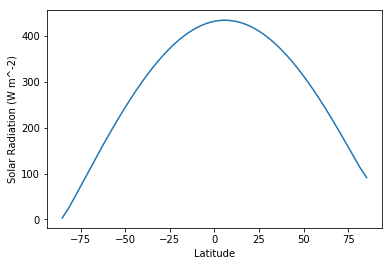

In [5]:
# FIGURE: Solar radiation over all latitudes at a given timestep

#print(times)

plt.figure()
plt.plot(model_lat,s_y_seasonal(times[3],t_end,y_T))
plt.xlabel("Latitude")
plt.ylabel("Solar Radiation (W m^-2)")
plt.show()

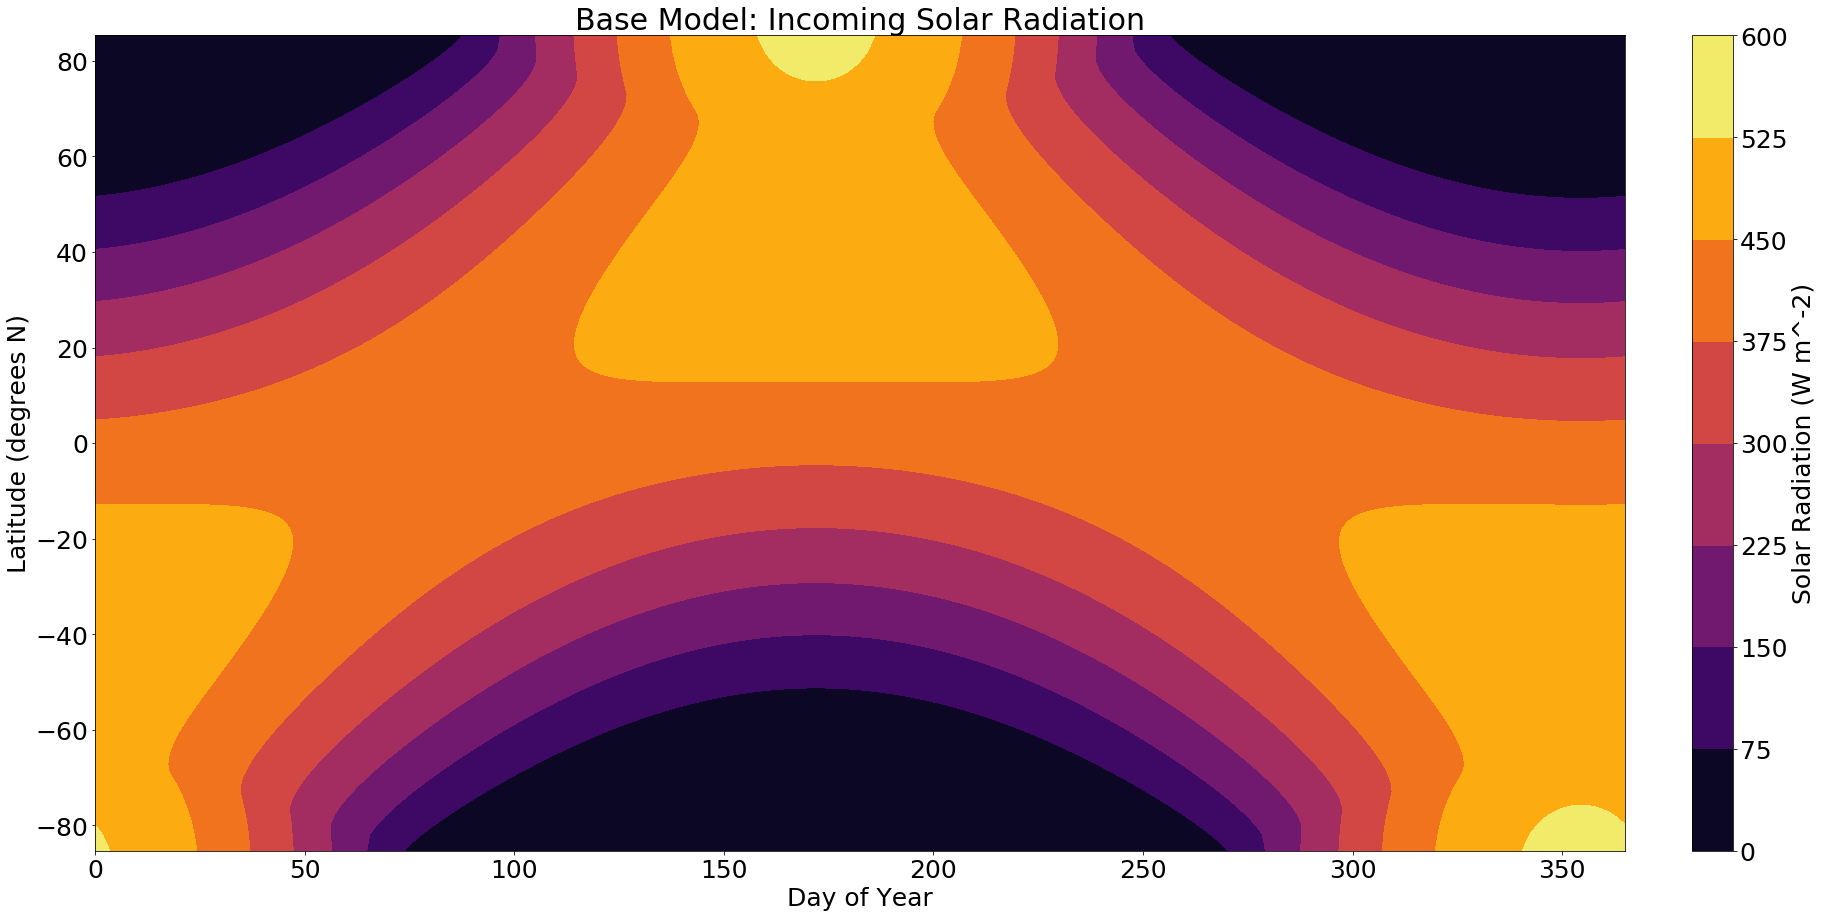

In [6]:
# Contour plot for solar radiation (shows which latitudes are receiving x amount of radiation on a certain day of the year)
# Colormaps: https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

dates = np.linspace(0,365,365)*86400
Q_all = np.empty([365,300])
j = 0
for i in dates:
    Q_time = s_y_seasonal(i,t_end,y_T)
    Q_all[j] = Q_time
    j = j+1

Q_all = np.array(Q_all)
model_lat = np.array(model_lat)

contour_levels = np.linspace(0,600,9)

ax = plt.figure(figsize=(30,15)).add_subplot(111)
CS = ax.contourf(dates/86400,model_lat,np.transpose(Q_all),levels=contour_levels,cmap='inferno')
    # OG Colormap: YlGnBu_r
cbar = plt.colorbar(CS,fraction=0.046, pad=0.04)
ax.set_xlabel("Day of Year",fontsize=25)
plt.xticks(fontsize=25)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel("Solar Radiation (W m^-2)",fontsize=25)
ax.set_ylabel("Latitude (degrees N)",fontsize=25)
plt.yticks(fontsize=25)
ax.set_title("Base Model: Incoming Solar Radiation",fontsize=30)
plt.savefig("base_solar_radiation_contour_plot.jpg")
plt.show()


In [7]:
# TIME INTEGRATION OF SURFACE TEMPERATURE

def RHS_lat_time_temp(t,T):
    
    # Compute energy flux F at interfaces
    F = np.zeros(N+1)
    F[1:N] = -D*(1-y_T[1:N]**2)*(T[1:N]-T[0:N-1])/dy
    F[0] = 0 # apply no flux b.c. at y=-1
    F[N] = 0 # apply no flux b.c. at y=+1
    
    # Compute diffusion term at the segment centers
    diffusion = -(F[1:N+1]-F[0:N])/dy
    
    # Compute right-hand-side of the equation
    heat_diff = diffusion/Cbar
    ASR_alb_time_temp = (s_y_seasonal(t,t_end,y_T))*(1-alpha_t(t,t_end,y_T,T))/Cbar # with albedo and solar parameterization
    OLR = (1-(eps/2))*sigma*T**4/Cbar
    rhs = ASR_alb_time_temp - OLR + heat_diff
    return rhs


# Call time integrator to solve the equation numerically (as in class 18)
solution = solve_ivp(RHS_lat_time_temp, (0,t_end), T0, "Radau", times, max_step=dt )

# Extract time and temperature fields from the solution
t_lat_time_temp = solution.t
T_lat_time_temp = solution.y


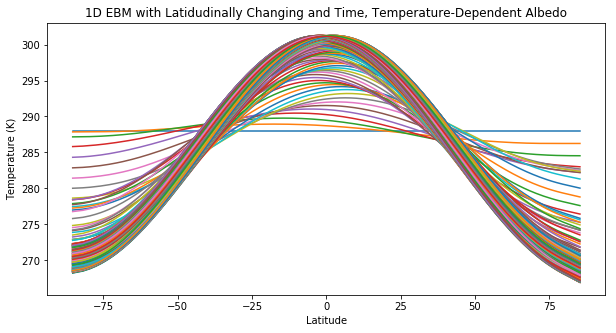

In [8]:
# Plot temperatures vs latitude for all time steps
fig = plt.figure(figsize=(10,5))
plt.plot(model_lat, T_lat_time_temp,label='Surface temperature');
plt.xlabel('Latitude')
plt.ylabel('Temperature (K)')
plt.title('1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo')
#plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
#plt.savefig('1D_EBM_albedo_comparisons.jpg')
plt.show()

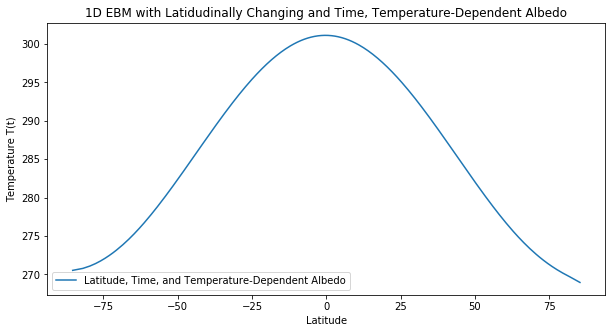

In [9]:
# Plot final temperature vs latitude
fig = plt.figure(figsize=(10,5))
plt.plot(model_lat, T_lat_time_temp[:,-1],label='Latitude, Time, and Temperature-Dependent Albedo');
plt.xlabel('Latitude')
plt.ylabel('Temperature T(t)')
plt.title('1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo')
plt.legend()
#plt.savefig('1D_EBM_albedo_comparisons_last.jpg')
plt.show()

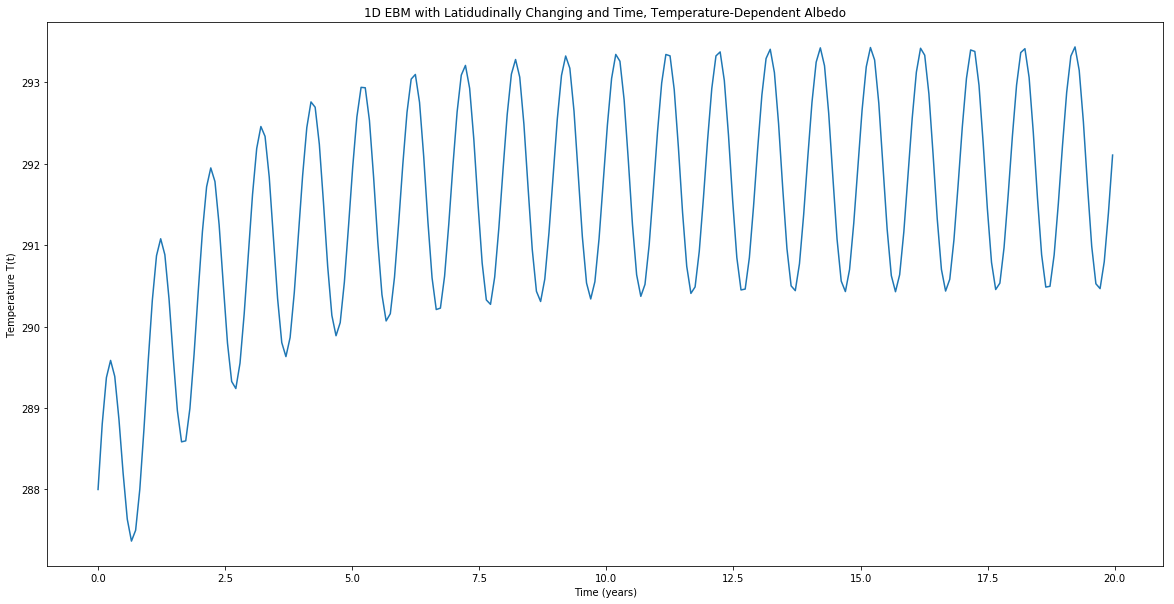

In [10]:
# Plot temperature vs time for one latitude
fig = plt.figure(figsize=(20,10))
plt.plot(t_lat_time_temp/years, T_lat_time_temp[70,:],label='Latitude, Time, and Temperature-Dependent Albedo'); 
    # Can pick a specific latitude here
plt.xlabel('Time (years)')
plt.ylabel('Temperature T(t)')
plt.title('1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo')
#plt.legend()
#plt.savefig('1D_EBM_albedo_comparisons_tempchange.jpg')
plt.show()

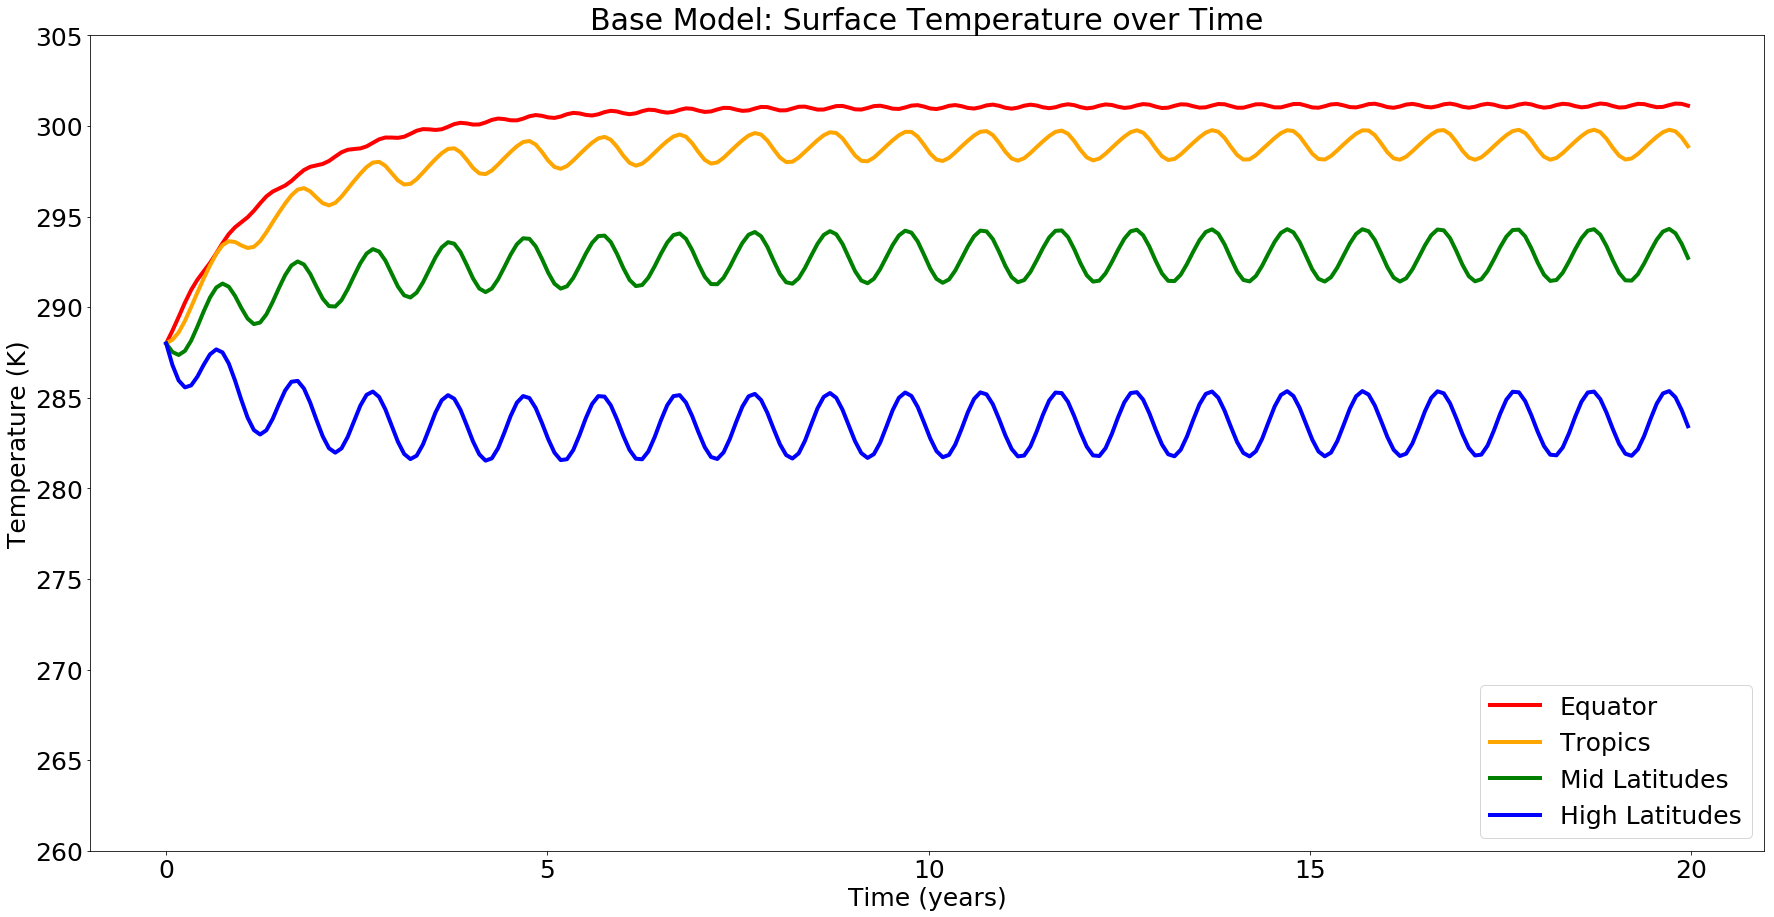

In [11]:
# Plot temperature vs time for several latitudes
fig = plt.figure(figsize=(30,15))
plt.plot(t_lat_time_temp/years, T_lat_time_temp[150,:],color='red',linewidth=4,label='Equator') # 0 deg N, band 150
plt.plot(t_lat_time_temp/years, T_lat_time_temp[188,:],color='orange',linewidth=4,label='Tropics') # 23 deg N, band 188
plt.plot(t_lat_time_temp/years, T_lat_time_temp[225,:],color='green',linewidth=4,label='Mid Latitudes') # 45 deg N, band 225
plt.plot(t_lat_time_temp/years, T_lat_time_temp[260,:],color='blue',linewidth=4,label='High Latitudes') # 66 def N, band 260
    # Can pick a specific latitude here
plt.xlabel('Time (years)',fontsize=25)
xticks=np.arange(0,21,5)
plt.xticks(xticks,fontsize=25)
plt.ylabel('Temperature (K)',fontsize=25)
yticks = np.arange(260,310,5)
plt.yticks(yticks,fontsize=25)
plt.title('Base Model: Surface Temperature over Time',fontsize=30)
plt.legend(loc='lower right',fontsize=25)
plt.savefig('base_model_surface_temperature_over_time_d09.jpg')
plt.show()


### Experiment: Game of Thrones

Seasons play an important role in the series, and each season lasts for 365 x 5 or 1825 days, instead of 90 days. This would extend the length of the orbital period from 365 days (1 year) to 1825*4 or 7300 days. Essentially, we will model a world similar to Earth, but which orbits around the Sun at a much slower pace. We are interested to see how surface temperature changes by latitude when the length of the orbital period increases. 

In [12]:
# Physical constants 
Re     = 6.371E6        # Radius of Earth in m
eps    = 0.82           # Emissivity fraction
sigma  = 5.67E-8        # Stephan Boltzmann constant in W / m^2 / K^4
c_s    = 712            # heat capacity of Silicon rock in J /kg / K
rho_s  = 2650           # density of Silicon rock in kg/m^3
c_w    = 4000           # heat capacity of water in J /kg / K
rho_w  = 1000           # density of water in kg/m^3
years  = 365.25*24*3600 # seconds in a year
years_GoT = 7300*24*3600 
S0     = 1361           # solar insolation in W m-2
dg2rad = np.pi/180.0    # converstion factor for degree to radians
days   = 24*3600        # seconds per day


# Set model parameters
alpha = 0.32             # Albedo of earth
eps   = 0.82             # Emissivity 
depth = 100              # Depth of ocean mixed layer/land active layer, in m


# Calculate heat capacity (70% ocean and 30% silicate land of 100 m depth)
vol= 4 *np.pi* Re**2 * depth                                 # Volume of top x-meters of earth (given by depth)
C_e = 0.7 * (c_w * vol * rho_w) + 0.3 * (c_s * vol * rho_s ) # heat capacity of earth in J K-1
Cbar  =  C_e/(4*np.pi*Re**2)                                 # heat capacity per unit area in J m-2 K-1 


# Create grid and set initial conditions
N     = 300                         # set number of segments
y_F   = np.linspace(-1,1,N+1)       # set position of interfaces
y_T   = (y_F[0:N]+y_F[1:N+1])/2     # set position of midpoints
dy    = y_F[1]-y_F[0]               # get segment length
model_lat   = np.arcsin(y_T)/dg2rad       # latitude at segment centers


# Set the diffusion coefficient
D     = 0.9       # diffusion coefficient (previously 0.5)


# Set time integration parameters
t_end = 2*years_GoT                   # integration end time (previously 1*years!)
t_end_GoT = 5*years_GoT      # integration end time (~ 15 years to stabilize)
dt_GoT    = 50*days                    # time integration maxium step size (previously 10 days)
out_dt_GoT = 150*days                    # time between plots (previously 30*days!)
times = np.arange(0,t_end,out_dt)  # array of timesteps for output
times_GoT = np.arange(0,t_end_GoT,out_dt_GoT)  # array of timesteps for output


# Set initial conditions 
T0 = 288 + 0*y_T                     # constant initial temperature    

In [13]:
# ALBEDO FUNCTIONS

#Latitudinally changing albedo
def albedo(y):
    P2 = 1/2* (3*y**2-1)
    alb = alpha + 0.25*P2
    return(alb)  

# Time-varying albedo function
def alb_GoT(t,t_end_GoT,y):
    a =albedo(y)
    for i in range(N): # OG 10000
        if (t>=40*years_GoT) and (t<=60*years_GoT):
            m = (a[i]- 0.985*a[i])/(20*years_GoT)
            b = a[i]-60*years_GoT*m
            a[i] = m*t+b
    return a

# Latitudinally changing/temperature and time dependent albedo. (from 7500 Midterm Solution)
def alpha_t_GoT(t,t_end_GoT,y,T,option=1):
    if option==3:
        a = alb_GoT(t,t_end_GoT,y)
    else: 
        a = albedo(y) 
    for i in range(N):
        if T[i] <=(273.15-25):
            a[i]=0.55
        else:
            a[i]=a[i]
    type(a)        
    return a



In [14]:
# SOLAR FORCING FUNCTIONS

# Latitudinal varying solar radiation, based on North (1975) and Wash & McGhee (2013) 
def s_y(y):
    s=1.241-0.723*y**2
    return(s)  


# LATITUDINALLY AND SEASONALLY VARYING SOLAR RADIATION -- for each Julian Day
def s_y_seasonal_GoT(t,t_end_GoT,y):
    t_days = t/days # t is in seconds, this converts t to days
    JD_GoT = np.mod(t_days,7300) # Julian Day: subtracts the number of whole years from t
    delta_GoT = 23.45*np.cos(2*np.pi*(JD_GoT-3440)/7300) # Calculate declination angle for JD (starts at Jan. 1)
        # Note: declination angle is the angle at which the Sun is directly overhead for a given Julian day
    delta_array_GoT = np.repeat(delta_GoT,N)
    val_GoT = -np.tan(delta_array_GoT*dg2rad)*np.tan(model_lat*dg2rad)
    val_GoT = np.where((val_GoT<-1.0),-1.0,val_GoT) # for at the poles for length of daylight (dark or sunny all day)
    val_GoT = np.where((val_GoT>1.0),1.0,val_GoT)
    h0=np.arccos(val_GoT) # hour angle
    # Q is for solar forcing
    Q = (S0/np.pi)*(h0*np.sin(model_lat*dg2rad)*np.sin(delta_array_GoT*dg2rad) + np.cos(model_lat*dg2rad)*np.cos(delta_array_GoT*dg2rad)*np.sin(h0))
    return(Q)


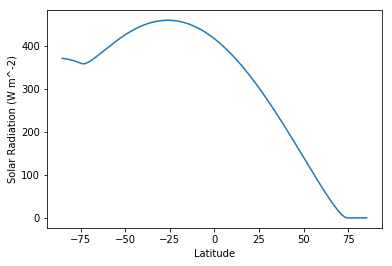

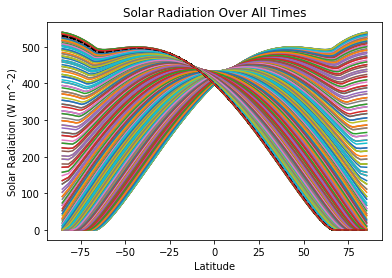

In [15]:
# FIGURE: Solar radiation over all latitudes

plt.figure()
plt.plot(model_lat,s_y_seasonal_GoT(times_GoT[5],t_end_GoT,y_T))
plt.xlabel("Latitude")
plt.ylabel("Solar Radiation (W m^-2)")
plt.show()

# plot Solar Radiation over all times and latitude
for i in range(len(times_GoT)):
    plt.plot(model_lat,s_y_seasonal_GoT(times_GoT[0],t_end_GoT,y_T),linestyle='--',color='k') # indicate start
    plt.plot(model_lat,s_y_seasonal_GoT(times_GoT[i],t_end_GoT,y_T))
plt.title('Solar Radiation Over All Times')
plt.xlabel("Latitude")
plt.ylabel("Solar Radiation (W m^-2)")
plt.show()

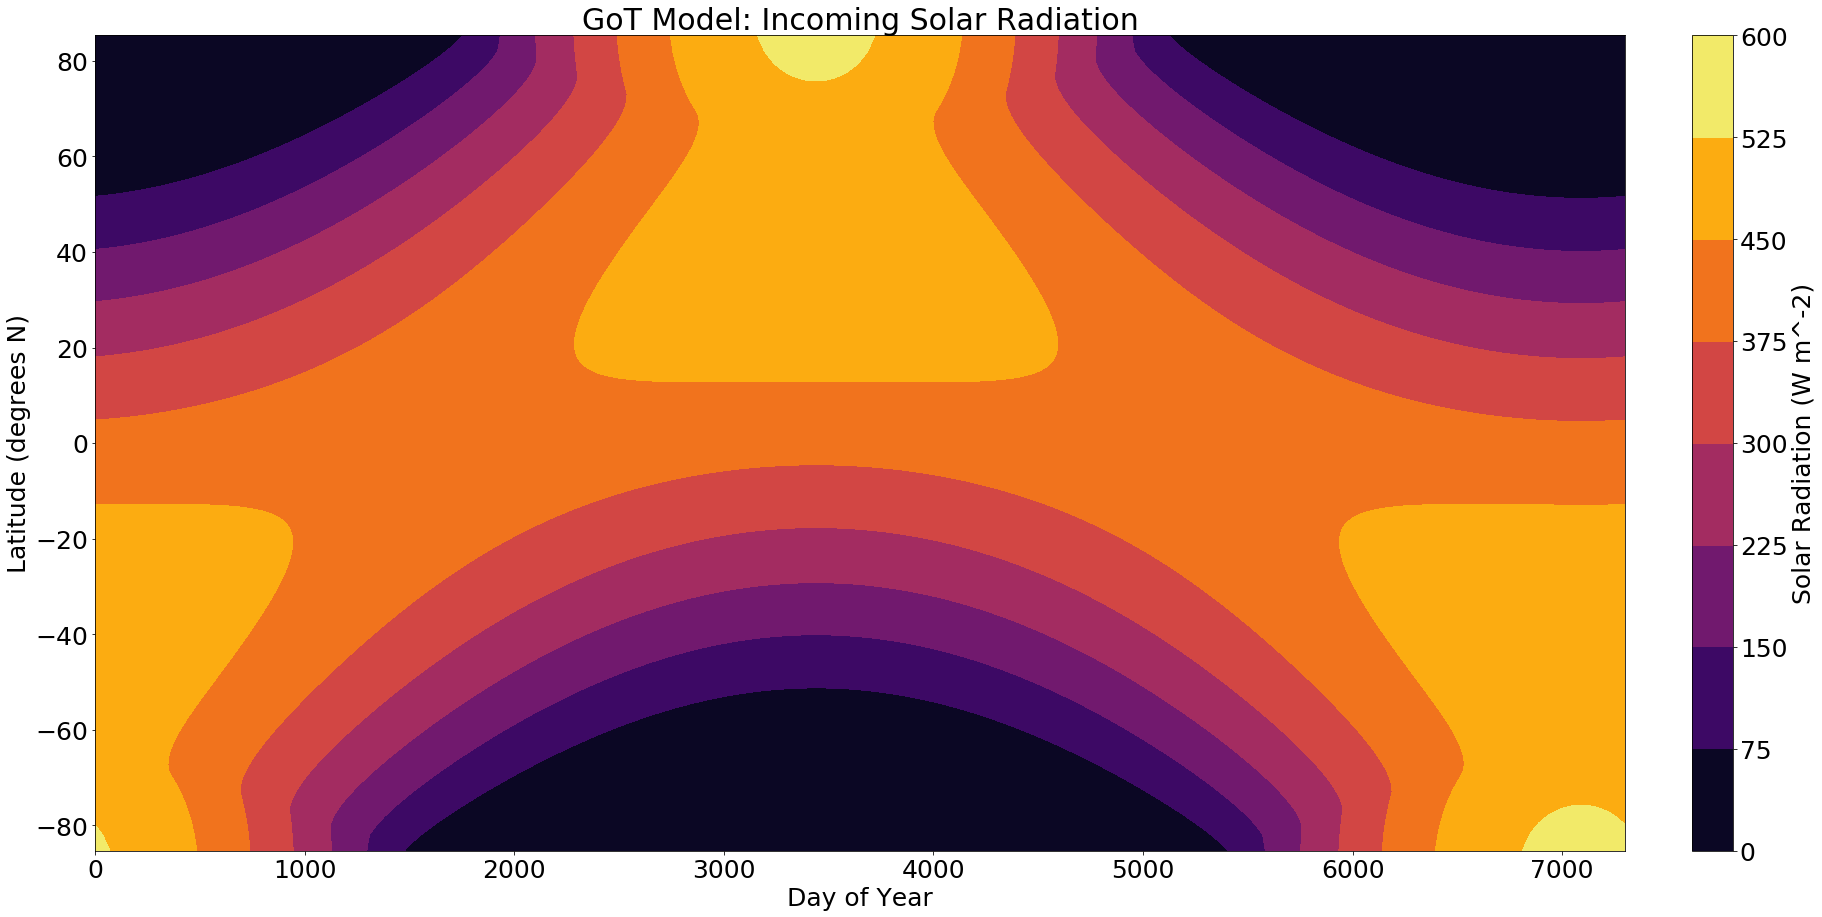

In [16]:
# Contour plot for solar radiation (shows which latitudes are receiving x amount of radiation on a certain day of the year)
# Colormaps: https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

dates_GoT = np.linspace(0,7300,7300)*86400
Q_all_GoT = np.empty([7300,300])
j = 0
for i in dates_GoT:
    Q_time_GoT = s_y_seasonal_GoT(i,t_end_GoT,y_T)
    Q_all_GoT[j] = Q_time_GoT
    j = j+1

Q_all_GoT = np.array(Q_all_GoT)
model_lat = np.array(model_lat)

contour_levels = np.linspace(0,600,9)

ax = plt.figure(figsize=(30,15)).add_subplot(111)
CS = ax.contourf(dates_GoT/86400,model_lat,np.transpose(Q_all_GoT),levels=contour_levels,cmap='inferno')
    # OG Colormap: YlGnBu_r
cbar = plt.colorbar(CS,fraction=0.046, pad=0.04)
ax.set_xlabel("Day of Year",fontsize=25)
plt.xticks(fontsize=25)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel("Solar Radiation (W m^-2)",fontsize=25)
ax.set_ylabel("Latitude (degrees N)",fontsize=25)
plt.yticks(fontsize=25)
ax.set_title("GoT Model: Incoming Solar Radiation",fontsize=30)
plt.savefig("GoT_solar_radiation_contour_plot.jpg")
plt.show()

In [17]:
# Time integration of temperature by latitude, using solve_ivp

def RHS_lat_time_temp_GoT(t,T):
    
    # Compute energy flux F at interfaces
    F     = np.zeros(N+1)
    F[1:N]= -D*(1-y_T[1:N]**2)*(T[1:N]-T[0:N-1])/dy
    F[0]  = 0              # apply no flux b.c. at y=-1
    F[N]  = 0               # apply no flux b.c. at y=+1
    
    # Compute diffusion term at the segment centers
    diffusion = -(F[1:N+1]-F[0:N])/dy
    
    # Compute right-hand-side of the equation
    heat_diff = diffusion/Cbar
    ASR_alb_time_temp_GoT = (s_y_seasonal_GoT(t,t_end_GoT,y_T))*(1-alpha_t_GoT(t,t_end_GoT,y_T,T))/Cbar # with albedo and solar parameterization for GoT Model
    OLR = (1-(eps/2))*sigma*T**4/Cbar
    rhs_GoT = ASR_alb_time_temp_GoT - OLR + heat_diff
    return rhs_GoT


# Call time integrator to solve the equation numerically (as in class 18)
solution_GoT = solve_ivp(RHS_lat_time_temp_GoT, (0,t_end_GoT), T0, "Radau", times_GoT, max_step=dt )


# Extract time and temperature fields from the solution
t_lat_time_temp_GoT = solution_GoT.t
T_lat_time_temp_GoT = solution_GoT.y

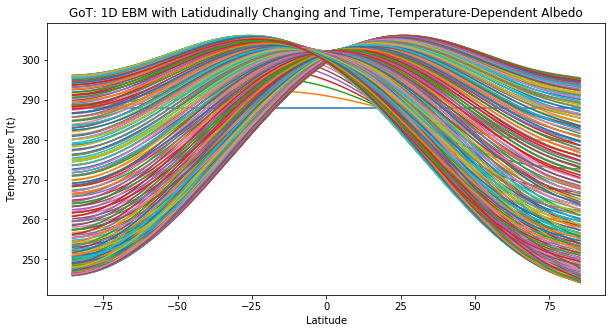

In [18]:
# Plot temperatures vs latitude for all time steps
fig = plt.figure(figsize=(10,5))
plt.plot(model_lat, T_lat_time_temp_GoT,label='Latitude, Time, and Temperature-Dependent Albedo');
plt.xlabel('Latitude')
plt.ylabel('Temperature T(t)')
plt.title('GoT: 1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo')
#plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
#plt.savefig('1D_EBM_albedo_comparisons_GoT.jpg')
plt.show()

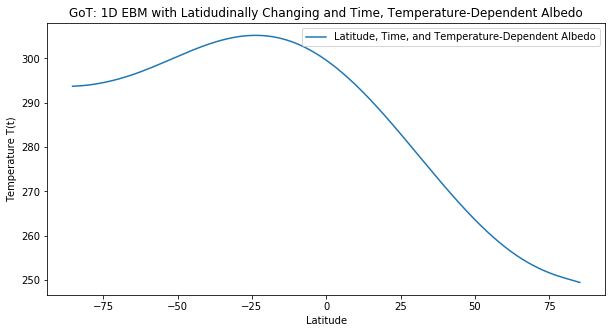

In [19]:
# Plot final temperature vs latitude
fig = plt.figure(figsize=(10,5))
plt.plot(model_lat, T_lat_time_temp_GoT[:,-1],label='Latitude, Time, and Temperature-Dependent Albedo');
plt.xlabel('Latitude')
plt.ylabel('Temperature T(t)')
plt.title('GoT: 1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo')
plt.legend()
#plt.savefig('1D_EBM_albedo_comparisons_GoT_last.jpg')
plt.show()

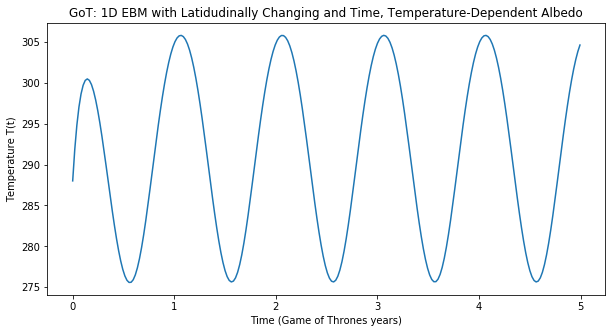

In [20]:
# Plot temperature vs time for all latitudes
fig = plt.figure(figsize=(10,5))
plt.plot(t_lat_time_temp_GoT/years_GoT, T_lat_time_temp_GoT[70,:],label='Latitude, Time, and Temperature-Dependent Albedo'); 
    # Can pick a specific latitude here
plt.xlabel('Time (Game of Thrones years)')
plt.ylabel('Temperature T(t)')
plt.title('GoT: 1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo')
#plt.legend()
#plt.savefig('1D_EBM_albedo_comparisons_GoT_tempchange.jpg')
plt.show()

# Further GoT Changes:
1. Radius (Re_GoT) <br>
2. Heat Capacity <br>

In [21]:
# 1. Changing Radius of GoT world = 6915 km radius

# Physical constants 
Re     = 6.371E6        # Radius of Earth in m
Re_GoT = 6.915E6  # Radius of GoT world in m
eps    = 0.5           # Emissivity fraction
sigma  = 5.67E-8        # Stephan Boltzmann constant in W / m^2 / K^4
c_s    = 712            # heat capacity of Silicon rock in J /kg / K
rho_s  = 2650           # density of Silicon rock in kg/m^3
c_w    = 4000           # heat capacity of water in J /kg / K

# added heat capacity of icy snow due to the Wall in the north 
c_snow = 878            # heat capacity of snow in J / kg / K
rho_snow = 800          # density of icy snow in kg/m^3

# added heat capacity of vegetated land due to Dothraki Sea and 
c_v =  830              # heat capacity of vegetated land in J / kg / K
rho_v = 5               # density of vegetation in kg/m^3

# added heat capacity of dry and wet sand due to deserts
c_sand = 1000           # avg heat capacity of dry and wet sand in J / kg / K
rho_sand = 1400         # density of sand in kg/m^3

rho_w  = 1000           # density of water in kg/m^3
years  = 365.25*24*3600 # seconds in a year
years_GoT = 7300*24*3600 
S0     = 1361           # solar insolation in W m-2
dg2rad = np.pi/180.0    # converstion factor for degree to radians
days   = 24*3600        # seconds per day


# Set model parameters
alpha = 0.32             # Albedo of earth
eps   = 0.82             # Emissivity 
depth = 100              # Depth of ocean mixed layer/land active layer, in m


# Calculate heat capacity (70% ocean and 30% silicate land of 100 m depth)
vol_GoT= 4 *np.pi* Re_GoT**2 * depth                        # Volume of top x-meters of GoT (given by depth)

# heat capacity of GoT in J K-1:
C_e_GoT = (0.63 * (c_w * vol_GoT * rho_w) + 0.2 * (c_s * vol_GoT * rho_s ) + 0.07 * (c_snow * vol_GoT * rho_snow) + \
           0.08 * (c_v * vol_GoT * rho_v) + 0.02 * (c_sand * vol_GoT * rho_sand))

Cbar_GoT  =  C_e_GoT/(4*np.pi*Re_GoT**2)                        # heat capacity per unit area in J m-2 K-1 

# comparison of Earth vs. GoT world with changing radius
print(vol,' vs. ',vol_GoT)
print(C_e,' vs. ',C_e_GoT)
print(Cbar,' vs. ',Cbar_GoT)

# Set the diffusion coefficient
D     = 0.9       # diffusion coefficient (previously 0.5)


# Set time integration parameters
t_end = 2*years_GoT                   # integration end time (previously 1*years!)
t_end_GoT = 5*years_GoT      # integration end time (~ 15 years to stabilize)
dt_GoT    = 50*days                    # time integration maxium step size (previously 10 days)
out_dt_GoT = 150*days                    # time between plots (previously 30*days!)
times = np.arange(0,t_end,out_dt)  # array of timesteps for output
times_GoT = np.arange(0,t_end_GoT,out_dt_GoT)  # array of timesteps for output


# Set initial conditions 
T0 = 288 + 0*y_T                     # constant initial temperature    

5.1006447190978824e+16  vs.  6.008889711002007e+16
1.7168974150272234e+23  vs.  1.7875605645671427e+23
336603999.99999994  vs.  297485999.99999994


In [22]:
# Time integration of temperature by latitude, using solve_ivp

def RHS_lat_time_temp_GoT_rad(t,T):
    
    # Compute energy flux F at interfaces
    F     = np.zeros(N+1)
    F[1:N]= -D*(1-y_T[1:N]**2)*(T[1:N]-T[0:N-1])/dy
    F[0]  = 0              # apply no flux b.c. at y=-1
    F[N]  = 0               # apply no flux b.c. at y=+1
    
    # Compute diffusion term at the segment centers
    diffusion = -(F[1:N+1]-F[0:N])/dy
    
    # Compute right-hand-side of the equation
    heat_diff = diffusion/Cbar
    ASR_alb_time_temp_GoT = (s_y_seasonal_GoT(t,t_end_GoT,y_T))*(1-alpha_t_GoT(t,t_end_GoT,y_T,T))/Cbar # with albedo and solar parameterization for GoT Model
    OLR = (1-(eps/2))*sigma*T**4/Cbar
    rhs_GoT = ASR_alb_time_temp_GoT - OLR + heat_diff
    return rhs_GoT


# Call time integrator to solve the equation numerically (as in class 18)
solution_GoT_rad = solve_ivp(RHS_lat_time_temp_GoT_rad, (0,t_end_GoT), T0, "Radau", times_GoT, max_step=dt )


# Extract time and temperature fields from the solution
t_lat_time_temp_GoT_rad = solution_GoT_rad.t
T_lat_time_temp_GoT_rad = solution_GoT_rad.y

In [23]:
# Calculate heat capacity (70% ocean and 30% silicate land of 100 m depth)
vol_GoT_heat= 4 *np.pi* Re**2 * depth                        # Volume of top x-meters of GoT (given by depth)

# heat capacity of GoT in J K-1:
C_e_GoT_heat = (0.63 * (c_w * vol_GoT_heat * rho_w) + 0.2 * (c_s * vol_GoT_heat * rho_s ) + 0.07 * (c_snow * vol_GoT_heat * rho_snow) + \
           0.08 * (c_v * vol_GoT_heat * rho_v) + 0.02 * (c_sand * vol_GoT_heat * rho_sand))

Cbar_GoT_heat  =  C_e_GoT_heat/(4*np.pi*Re**2)                        # heat capacity per unit area in J m-2 K-1 

def RHS_lat_time_temp_GoT_heat(t,T):
    
    # Compute energy flux F at interfaces
    F     = np.zeros(N+1)
    F[1:N]= -D*(1-y_T[1:N]**2)*(T[1:N]-T[0:N-1])/dy
    F[0]  = 0              # apply no flux b.c. at y=-1
    F[N]  = 0               # apply no flux b.c. at y=+1
    
    # Compute diffusion term at the segment centers
    diffusion = -(F[1:N+1]-F[0:N])/dy
    
    # Compute right-hand-side of the equation
    heat_diff = diffusion/Cbar_GoT
    ASR_alb_time_temp_GoT = (s_y_seasonal_GoT(t,t_end_GoT,y_T))*(1-alpha_t_GoT(t,t_end_GoT,y_T,T))/Cbar_GoT # with albedo and solar parameterization for GoT Model
    OLR = (1-(eps/2))*sigma*T**4/Cbar_GoT
    rhs_GoT = ASR_alb_time_temp_GoT - OLR + heat_diff
    return rhs_GoT


# Call time integrator to solve the equation numerically (as in class 18)
solution_GoT_heat = solve_ivp(RHS_lat_time_temp_GoT_heat, (0,t_end_GoT), T0, "Radau", times_GoT, max_step=dt )


# Extract time and temperature fields from the solution
t_lat_time_temp_GoT_heat = solution_GoT_heat.t
T_lat_time_temp_GoT_heat = solution_GoT_heat.y

In [24]:
# Time integration of temperature by latitude, using solve_ivp

def RHS_lat_time_temp_GoT_rad_heat(t,T):
    
    # Compute energy flux F at interfaces
    F     = np.zeros(N+1)
    F[1:N]= -D*(1-y_T[1:N]**2)*(T[1:N]-T[0:N-1])/dy
    F[0]  = 0              # apply no flux b.c. at y=-1
    F[N]  = 0               # apply no flux b.c. at y=+1
    
    # Compute diffusion term at the segment centers
    diffusion = -(F[1:N+1]-F[0:N])/dy
    
    # Compute right-hand-side of the equation
    heat_diff = diffusion/Cbar_GoT
    ASR_alb_time_temp_GoT = (s_y_seasonal_GoT(t,t_end_GoT,y_T))*(1-alpha_t_GoT(t,t_end_GoT,y_T,T))/Cbar_GoT # with albedo and solar parameterization for GoT Model
    OLR = (1-(eps/2))*sigma*T**4/Cbar_GoT
    rhs_GoT = ASR_alb_time_temp_GoT - OLR + heat_diff
    return rhs_GoT


# Call time integrator to solve the equation numerically (as in class 18)
solution_GoT_rad_heat = solve_ivp(RHS_lat_time_temp_GoT_rad_heat, (0,t_end_GoT), T0, "Radau", times_GoT, max_step=dt )


# Extract time and temperature fields from the solution
t_lat_time_temp_GoT_rad_heat = solution_GoT_rad_heat.t
T_lat_time_temp_GoT_rad_heat = solution_GoT_rad_heat.y

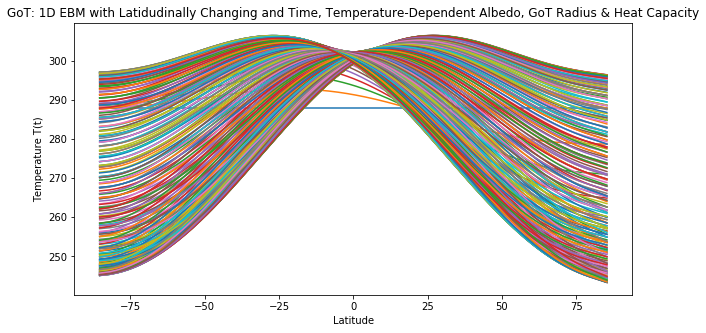

In [25]:

# Plot temperatures vs latitude for all time steps
fig = plt.figure(figsize=(10,5))
plt.plot(model_lat, T_lat_time_temp_GoT_rad_heat,label='Latitude, Time, and Temperature-Dependent Albedo');
plt.xlabel('Latitude')
plt.ylabel('Temperature T(t)')
plt.title('GoT: 1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo, GoT Radius & Heat Capacity')
#plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
#plt.savefig('1D_EBM_albedo_comparisons_GoT_rad_heat.jpg')
plt.show()

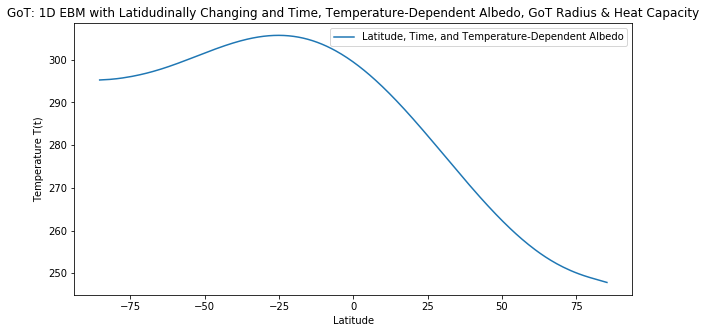

In [26]:

# Plot final temperature vs latitude
fig = plt.figure(figsize=(10,5))
plt.plot(model_lat, T_lat_time_temp_GoT_rad_heat[:,-1],label='Latitude, Time, and Temperature-Dependent Albedo');
plt.xlabel('Latitude')
plt.ylabel('Temperature T(t)')
plt.title('GoT: 1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo, GoT Radius & Heat Capacity')
plt.legend()
#plt.savefig('1D_EBM_albedo_comparisons_GoT_last_rad_heat.jpg')
plt.show()

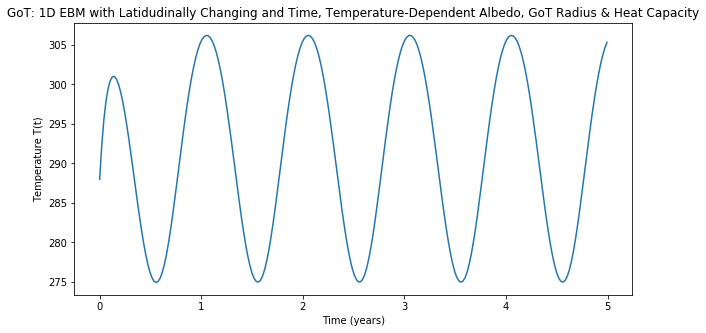

In [27]:

# Plot temperature vs time for all latitudes
fig = plt.figure(figsize=(10,5))
plt.plot(t_lat_time_temp_GoT_rad_heat/years_GoT, T_lat_time_temp_GoT_rad_heat[70,:],label='Latitude, Time, and Temperature-Dependent Albedo'); 
    # Can pick a specific latitude here
plt.xlabel('Time (years)')
plt.ylabel('Temperature T(t)')
plt.title('GoT: 1D EBM with Latidudinally Changing and Time, Temperature-Dependent Albedo, GoT Radius & Heat Capacity')
#plt.legend()
#plt.savefig('1D_EBM_albedo_comparisons_GoT_tempchange_rad_heat.jpg')
plt.show()

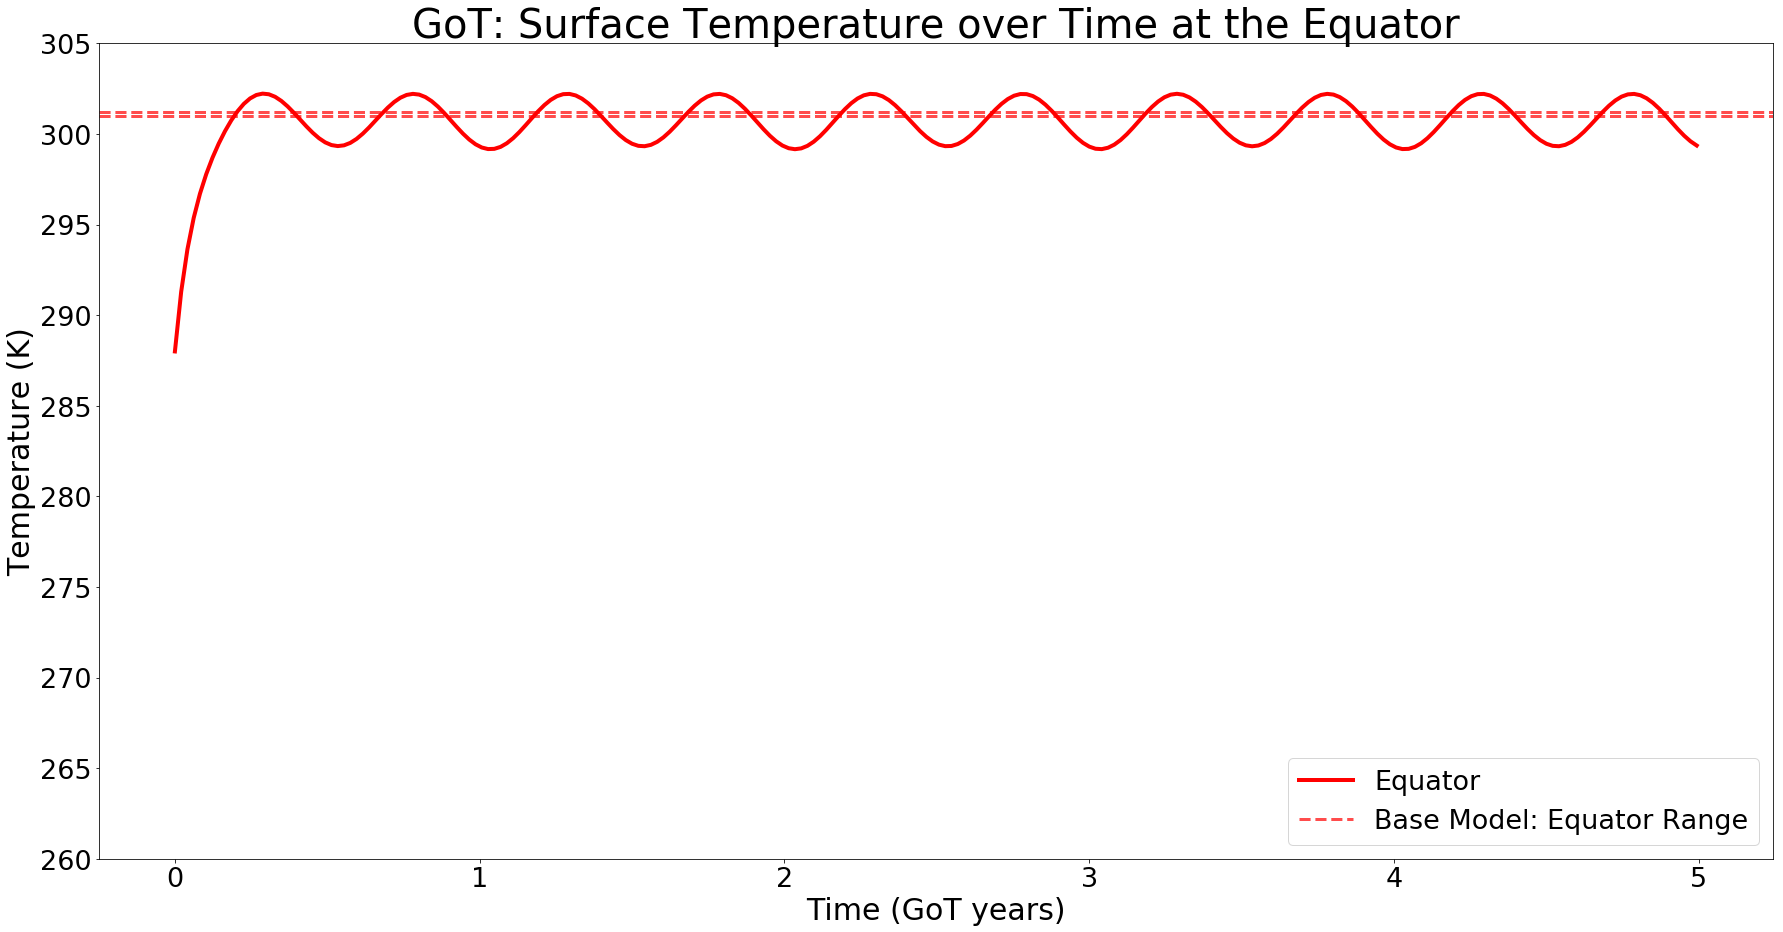

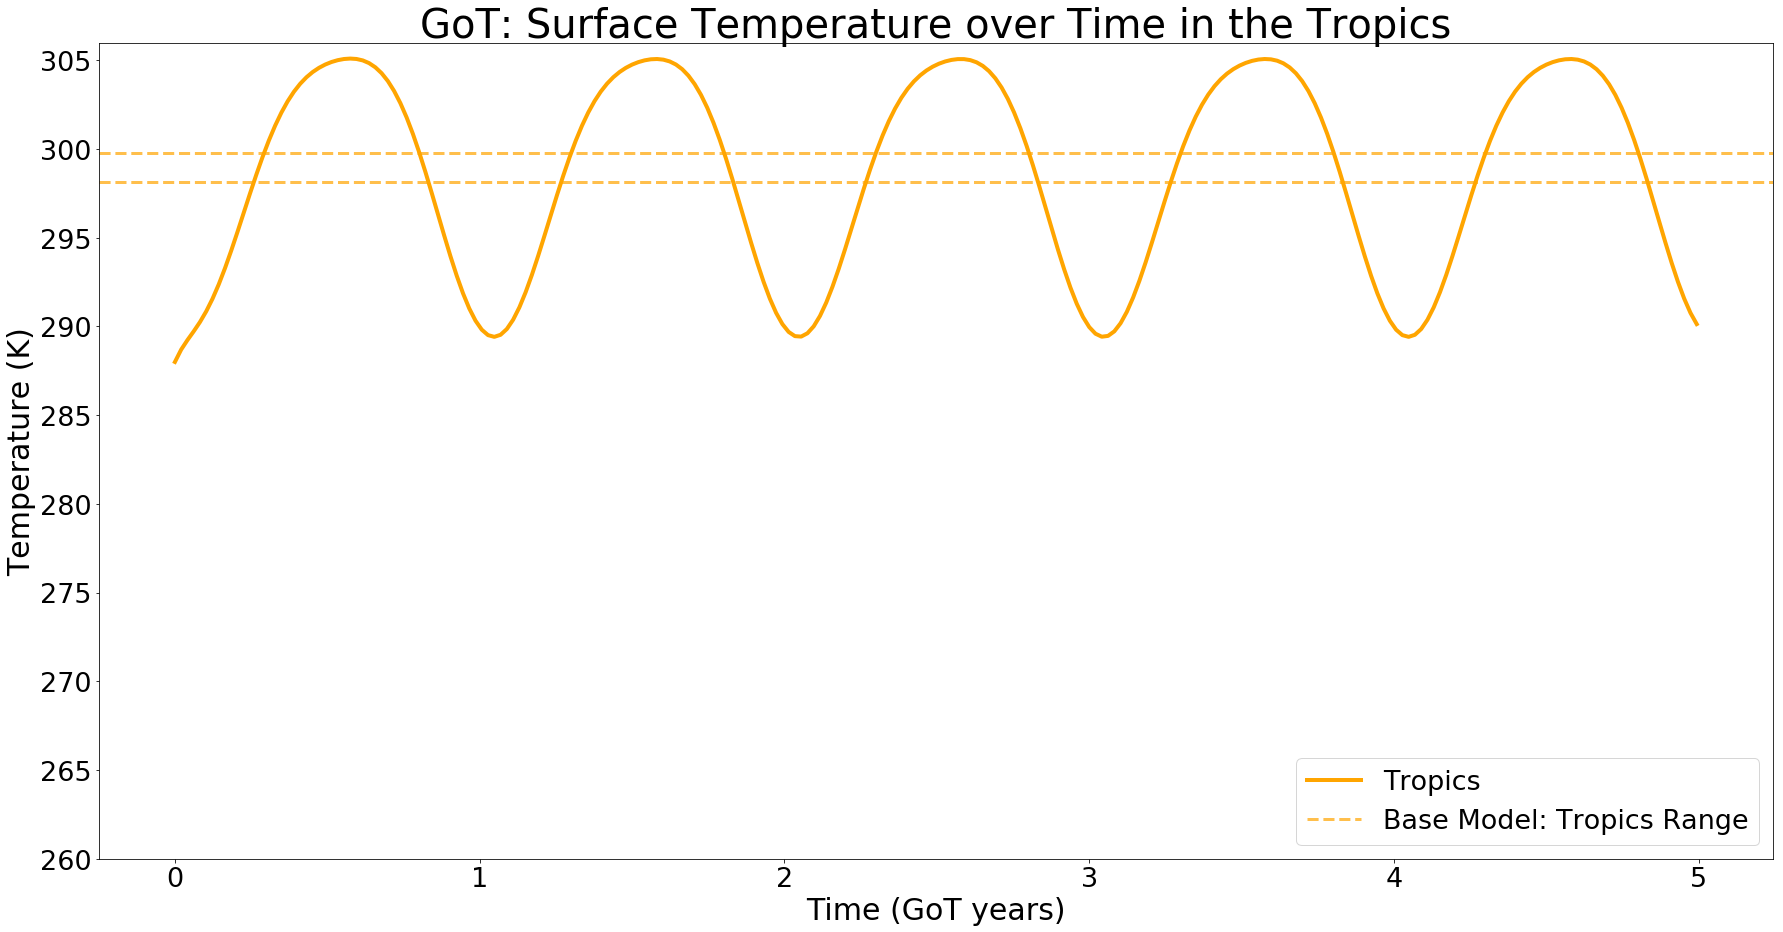

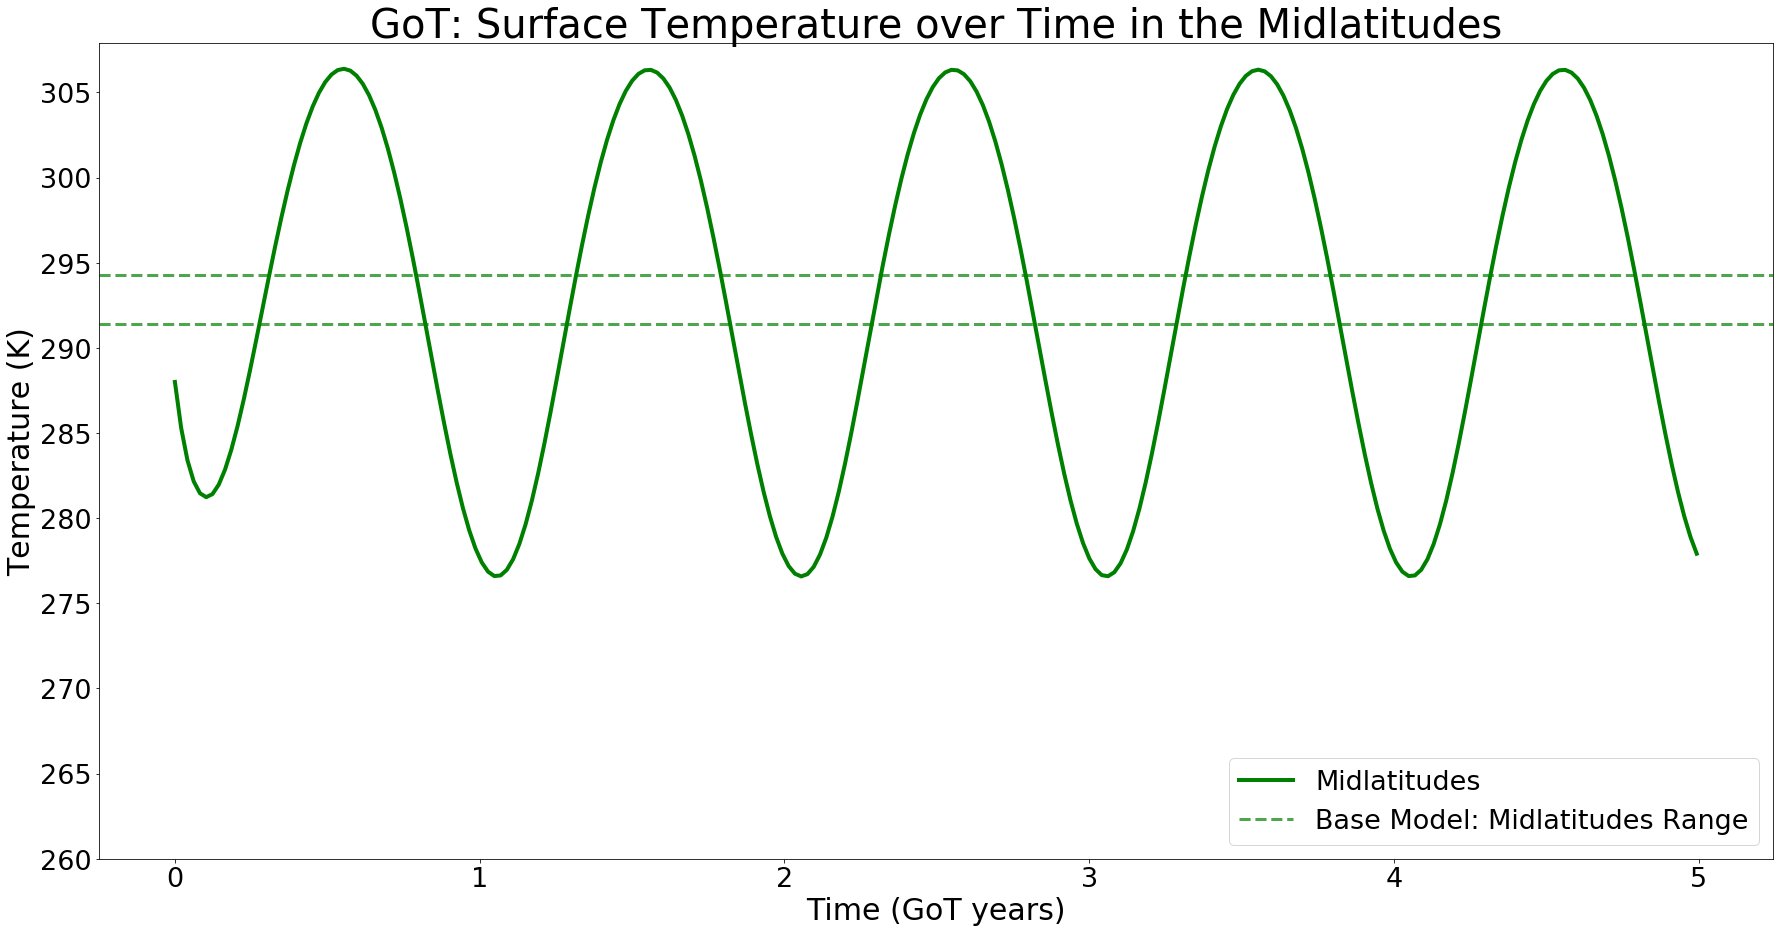

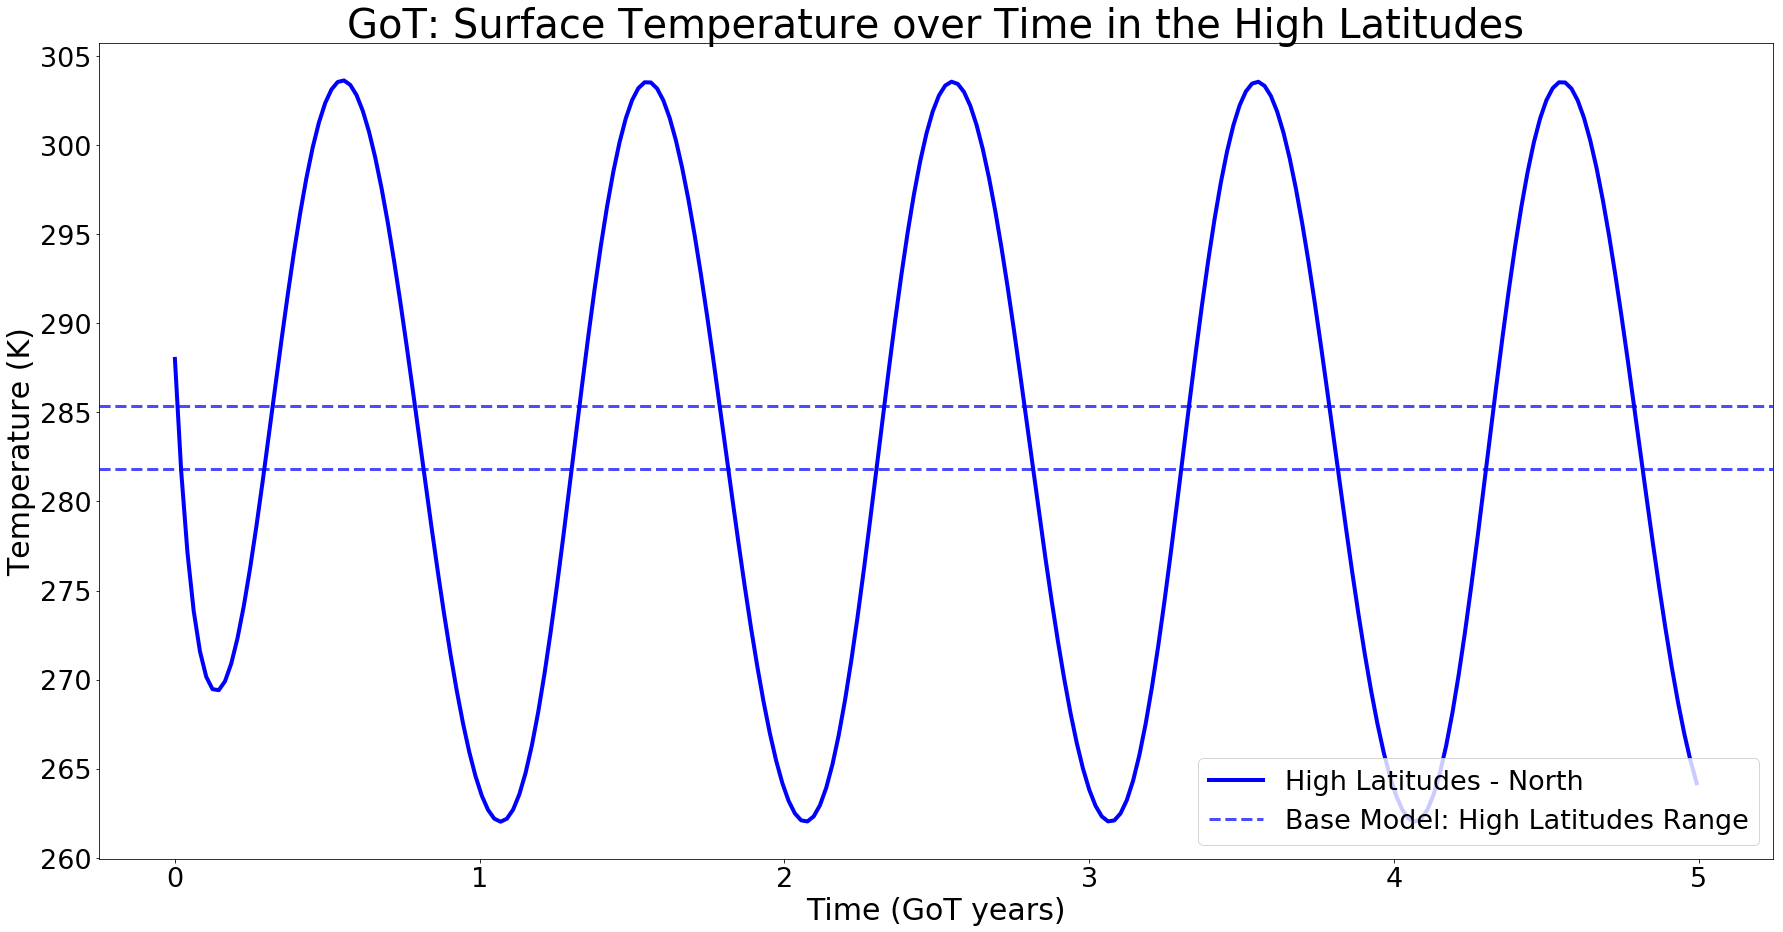

In [28]:
# Plot temperature vs time for specific latitudes-- compare with temperature range of the Earth Base Model



fig = plt.figure(figsize=(30,15))
plt.plot(t_lat_time_temp_GoT_rad_heat/years_GoT, T_lat_time_temp_GoT_rad_heat[150,:],c='r',linewidth=4,label='Equator');
plt.axhline(np.max(T_lat_time_temp[150,200:230]),linestyle='--',linewidth=3,c='r',alpha=0.7,label='Base Model: Equator Range')
plt.axhline(np.min(T_lat_time_temp[150,200:230]),linestyle='--',linewidth=3,c='r',alpha=0.7)
plt.xlabel('Time (GoT years)',fontsize=30)
plt.ylabel('Temperature (K)',fontsize=30)
plt.yticks(yticks,fontsize=27)
plt.xticks(fontsize=27)
plt.title('GoT: Surface Temperature over Time at the Equator',fontsize=40)
plt.legend(loc='lower right',fontsize=27)
plt.savefig('1D_EBM_albedo_comparisons_GoT_tempchange_rad_heat_equator_d09.jpg')
plt.show()


fig = plt.figure(figsize=(30,15))
plt.plot(t_lat_time_temp_GoT_rad_heat/years_GoT, T_lat_time_temp_GoT_rad_heat[188,:],c='orange',linewidth=4,label='Tropics');
plt.axhline(np.max(T_lat_time_temp[188,200:230]),linestyle='--',linewidth=3,c='orange',alpha=0.7,label='Base Model: Tropics Range')
plt.axhline(np.min(T_lat_time_temp[188,200:230]),linestyle='--',linewidth=3,c='orange',alpha=0.7)
plt.xlabel('Time (GoT years)',fontsize=30)
plt.ylabel('Temperature (K)',fontsize=30)
plt.yticks(yticks,fontsize=27)
plt.xticks(fontsize=27)
plt.title('GoT: Surface Temperature over Time in the Tropics',fontsize=40)
plt.legend(loc='lower right',fontsize=27)
plt.savefig('1D_EBM_albedo_comparisons_GoT_tempchange_rad_heat_tropics_d09.jpg')
plt.show()

fig = plt.figure(figsize=(30,15))
plt.plot(t_lat_time_temp_GoT_rad_heat/years_GoT, T_lat_time_temp_GoT_rad_heat[225,:],c='g',linewidth=4,label='Midlatitudes');
plt.axhline(np.max(T_lat_time_temp[225,200:230]),linestyle='--',linewidth=3,c='g',alpha=0.7,label='Base Model: Midlatitudes Range')
plt.axhline(np.min(T_lat_time_temp[225,200:230]),linestyle='--',linewidth=3,c='g',alpha=0.7)
plt.xlabel('Time (GoT years)',fontsize=30)
plt.ylabel('Temperature (K)',fontsize=30)
plt.yticks(yticks,fontsize=27)
plt.xticks(fontsize=27)
plt.title('GoT: Surface Temperature over Time in the Midlatitudes',fontsize=40)
plt.legend(loc='lower right',fontsize=27)
plt.savefig('1D_EBM_albedo_comparisons_GoT_tempchange_rad_heat_midlatitudes_d09.jpg')
plt.show()

fig = plt.figure(figsize=(30,15))
plt.plot(t_lat_time_temp_GoT_rad_heat/years_GoT, T_lat_time_temp_GoT_rad_heat[260,:],c='b',linewidth=4,label='High Latitudes - North')
#plt.plot(t_lat_time_temp_GoT_rad_heat/years_GoT, T_lat_time_temp_GoT_rad_heat[40,:],c='b',linewidth=4,label='High Latitudes - South')
plt.axhline(np.max(T_lat_time_temp[260,200:230]),linestyle='--',linewidth=3,c='b',alpha=0.7,label='Base Model: High Latitudes Range')
plt.axhline(np.min(T_lat_time_temp[260,200:230]),linestyle='--',linewidth=3,c='b',alpha=0.7)
plt.xlabel('Time (GoT years)',fontsize=30)
plt.ylabel('Temperature (K)',fontsize=30)
plt.yticks(yticks,fontsize=27)
plt.xticks(fontsize=27)
plt.title('GoT: Surface Temperature over Time in the High Latitudes',fontsize=40)
plt.legend(loc='lower right',fontsize=27)
plt.savefig('1D_EBM_albedo_comparisons_GoT_tempchange_rad_heat_highlatitudes_d09.jpg')
plt.show()


# pick a mid latitude, tropical, and equator
# 

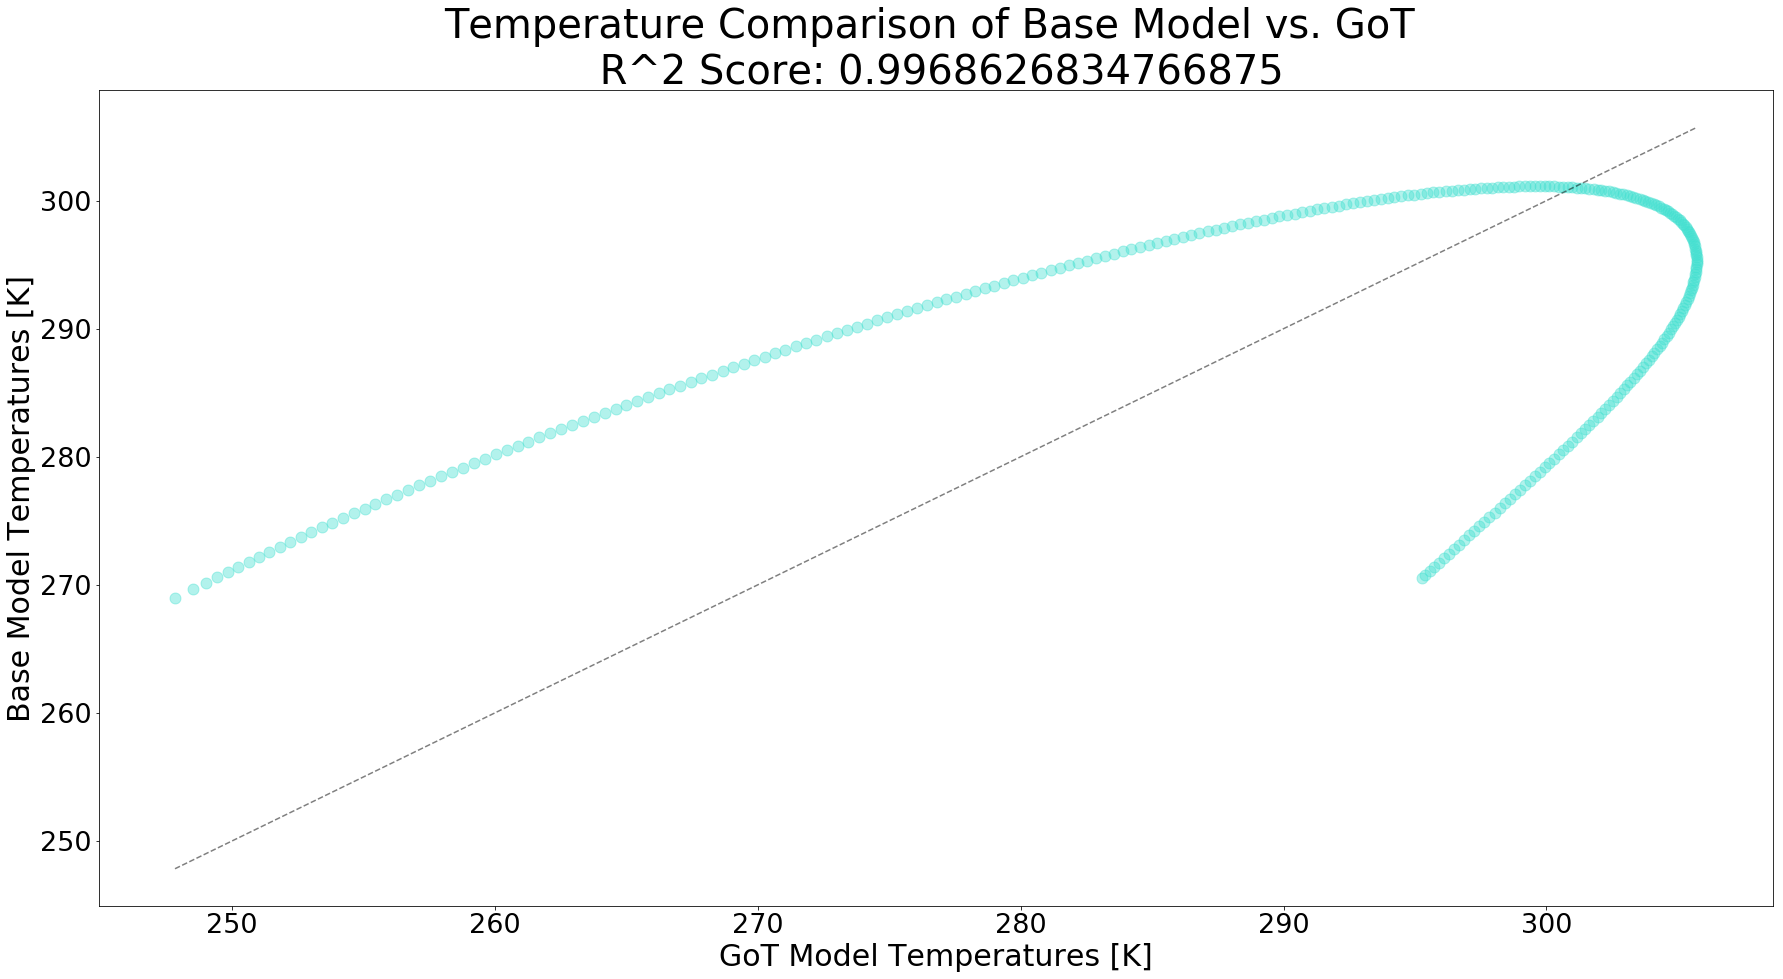

In [29]:
# compare what the change in radius does to the temps:
# add r^2 value
from sklearn.metrics import r2_score

yrange = np.linspace(min(min(T_lat_time_temp[:,-1]),min(T_lat_time_temp_GoT_rad_heat[:,-1])),\
                     max(max(T_lat_time_temp[:,-1]),max(T_lat_time_temp_GoT_rad_heat[:,-1]), 10))  # for one-to-one line

fig = plt.figure(figsize=(30,15))
plt.scatter(T_lat_time_temp_GoT_rad_heat[:,-1],T_lat_time_temp[:,-1],alpha = 0.4,c='turquoise',s=120)
plt.plot(yrange, yrange, '--',c='k',alpha = 0.5)
plt.title(f'Temperature Comparison of Base Model vs. GoT \n R^2 Score: {r2_score(T_lat_time_temp_GoT[:,-1], T_lat_time_temp_GoT_rad_heat[:,-1])}',fontsize=40)
plt.xlabel('GoT Model Temperatures [K]',fontsize=30)
plt.ylabel('Base Model Temperatures [K]',fontsize=30)
plt.yticks(fontsize=27)
plt.xticks(fontsize=27)
plt.savefig('Temp Comparison Base Model vs. Earth Radius_Heat_R2_d01.png')
plt.show()



# include figure in presentation

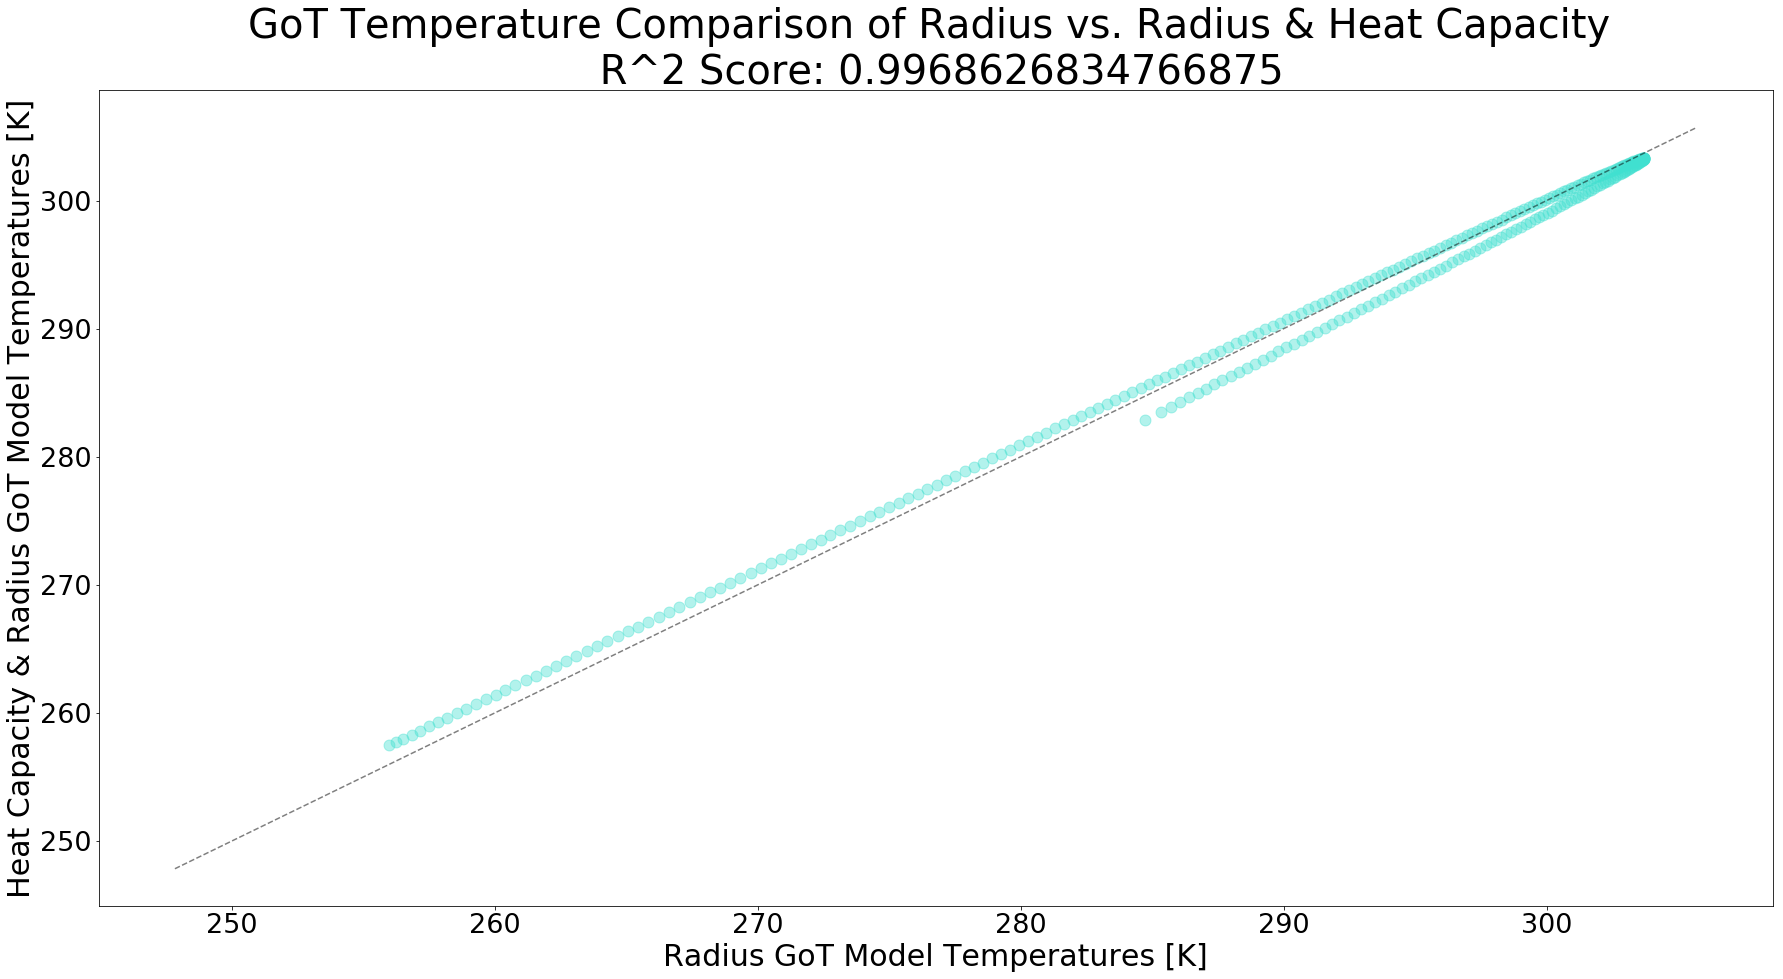

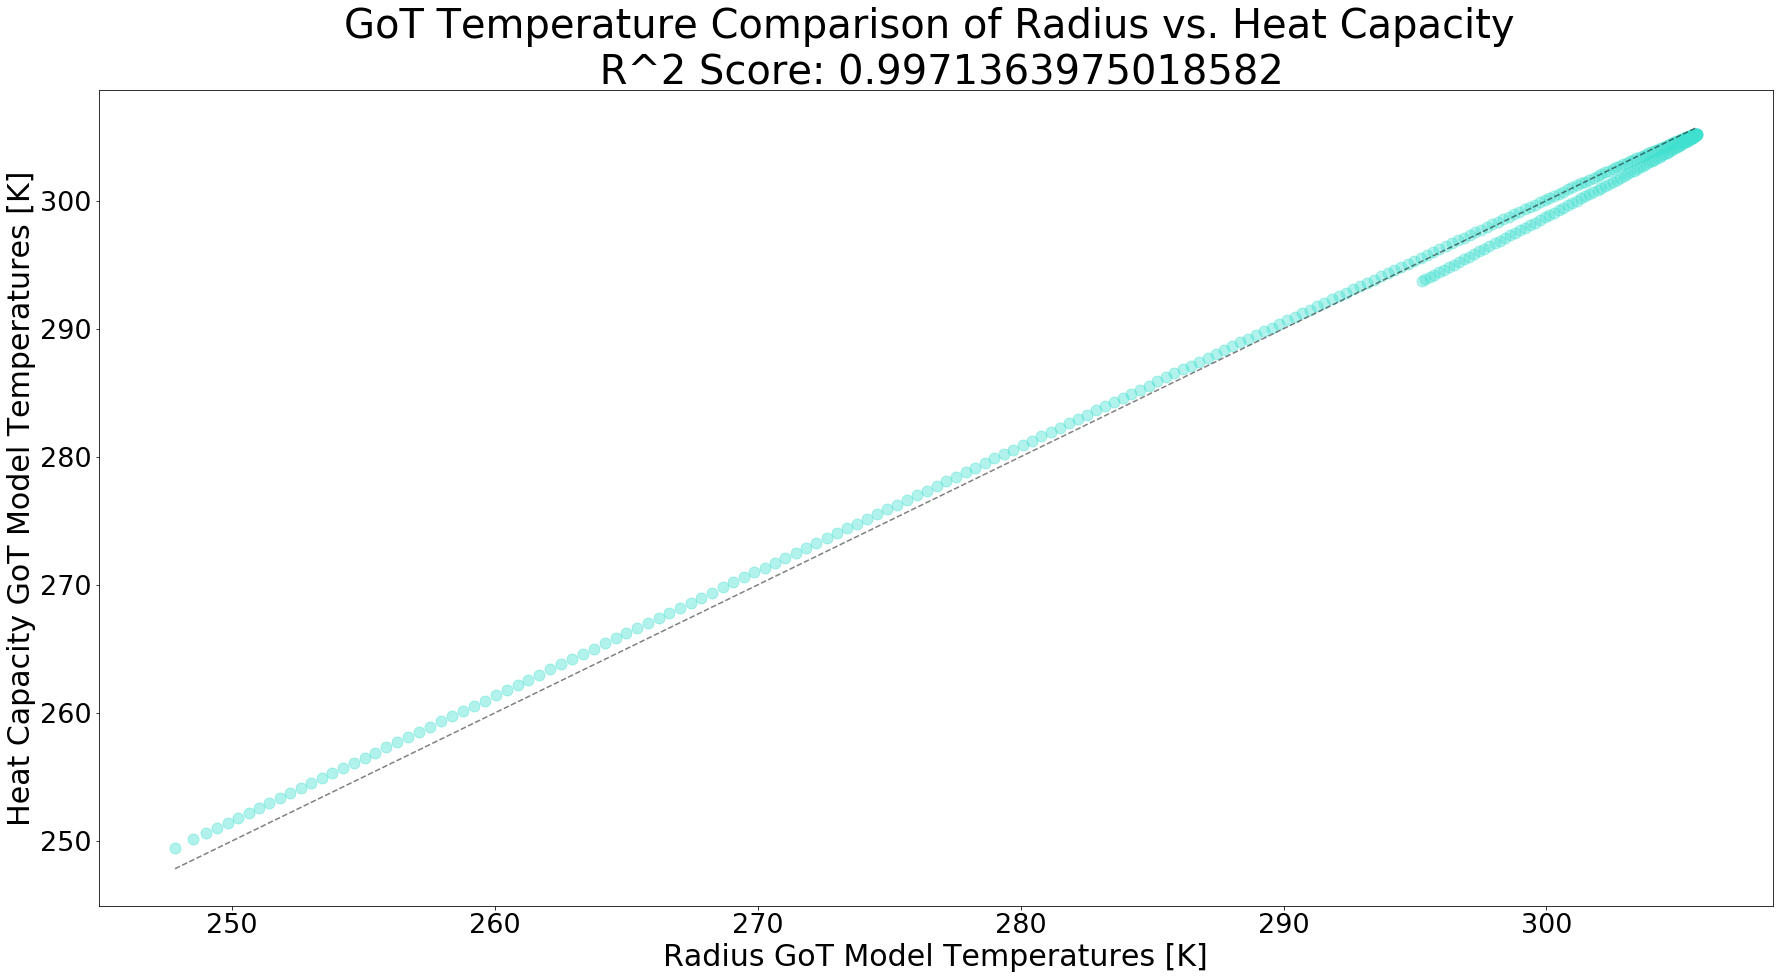

In [30]:
# compare what the change in radius does to the temps:
# add r^2 value
from sklearn.metrics import r2_score

# compare Got rad vs. Got rad & heat
yrange = np.linspace(min(min(T_lat_time_temp_GoT_rad[:,-1]),min(T_lat_time_temp_GoT_rad_heat[:,-1])),\
                     max(max(T_lat_time_temp_GoT_rad[:,-1]),max(T_lat_time_temp_GoT_rad_heat[:,-1]), 10))  # for one-to-one line

fig = plt.figure(figsize=(30,15))
plt.scatter(T_lat_time_temp_GoT_rad_heat[:,20],T_lat_time_temp_GoT_rad[:,20],alpha = 0.4,c='turquoise',s=120)
plt.plot(yrange, yrange, '--',c='k',alpha = 0.5)
plt.title(f'GoT Temperature Comparison of Radius vs. Radius & Heat Capacity \n R^2 Score: {r2_score(T_lat_time_temp_GoT_rad[:,-1], T_lat_time_temp_GoT_rad_heat[:,-1])}',fontsize=40)
plt.xlabel('Radius GoT Model Temperatures [K]',fontsize=30)
plt.ylabel('Heat Capacity & Radius GoT Model Temperatures [K]',fontsize=30)
plt.yticks(fontsize=27)
plt.xticks(fontsize=27)
#plt.savefig('GoT Temperature Comparison of Radius vs. Radius & Heat Capacity_R2_d09.png')
plt.show()


# compare Got rad vs. Got heat
yrange = np.linspace(min(min(T_lat_time_temp_GoT_rad[:,-1]),min(T_lat_time_temp_GoT_heat[:,-1])),\
                     max(max(T_lat_time_temp_GoT_rad[:,-1]),max(T_lat_time_temp_GoT_heat[:,-1]), 10))  # for one-to-one line

fig = plt.figure(figsize=(30,15))
plt.scatter(T_lat_time_temp_GoT_heat[:,-1],T_lat_time_temp_GoT_rad[:,-1],alpha = 0.4,c='turquoise',s=120)
plt.plot(yrange, yrange, '--',c='k',alpha = 0.5)
plt.title(f'GoT Temperature Comparison of Radius vs. Heat Capacity \n R^2 Score: {r2_score(T_lat_time_temp_GoT_heat[:,-1], T_lat_time_temp_GoT_rad[:,-1])}',fontsize=40)
plt.xlabel('Radius GoT Model Temperatures [K]',fontsize=30)
plt.ylabel('Heat Capacity GoT Model Temperatures [K]',fontsize=30)
plt.yticks(fontsize=27)
plt.xticks(fontsize=27)
plt.savefig('GoT Temperature Comparison of Radius vs. Heat Capacity_R2_d09.png')
plt.show()



In [31]:
# comparison of base model and GoT model to NCEP data

import xarray as xr
from xarray.ufuncs import sin, cos

# Get observational data and do some computations on them. This is slow, so don't re-run this code box unless needed
#  daily surface temperature from  NCEP reanalysis
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_temp = xr.open_dataset( ncep_url + "surface_gauss/skt.sfc.day.1981-2010.ltm.nc", decode_times=False)
ncep_temp_zon = ncep_temp.skt.mean(dim='lon')



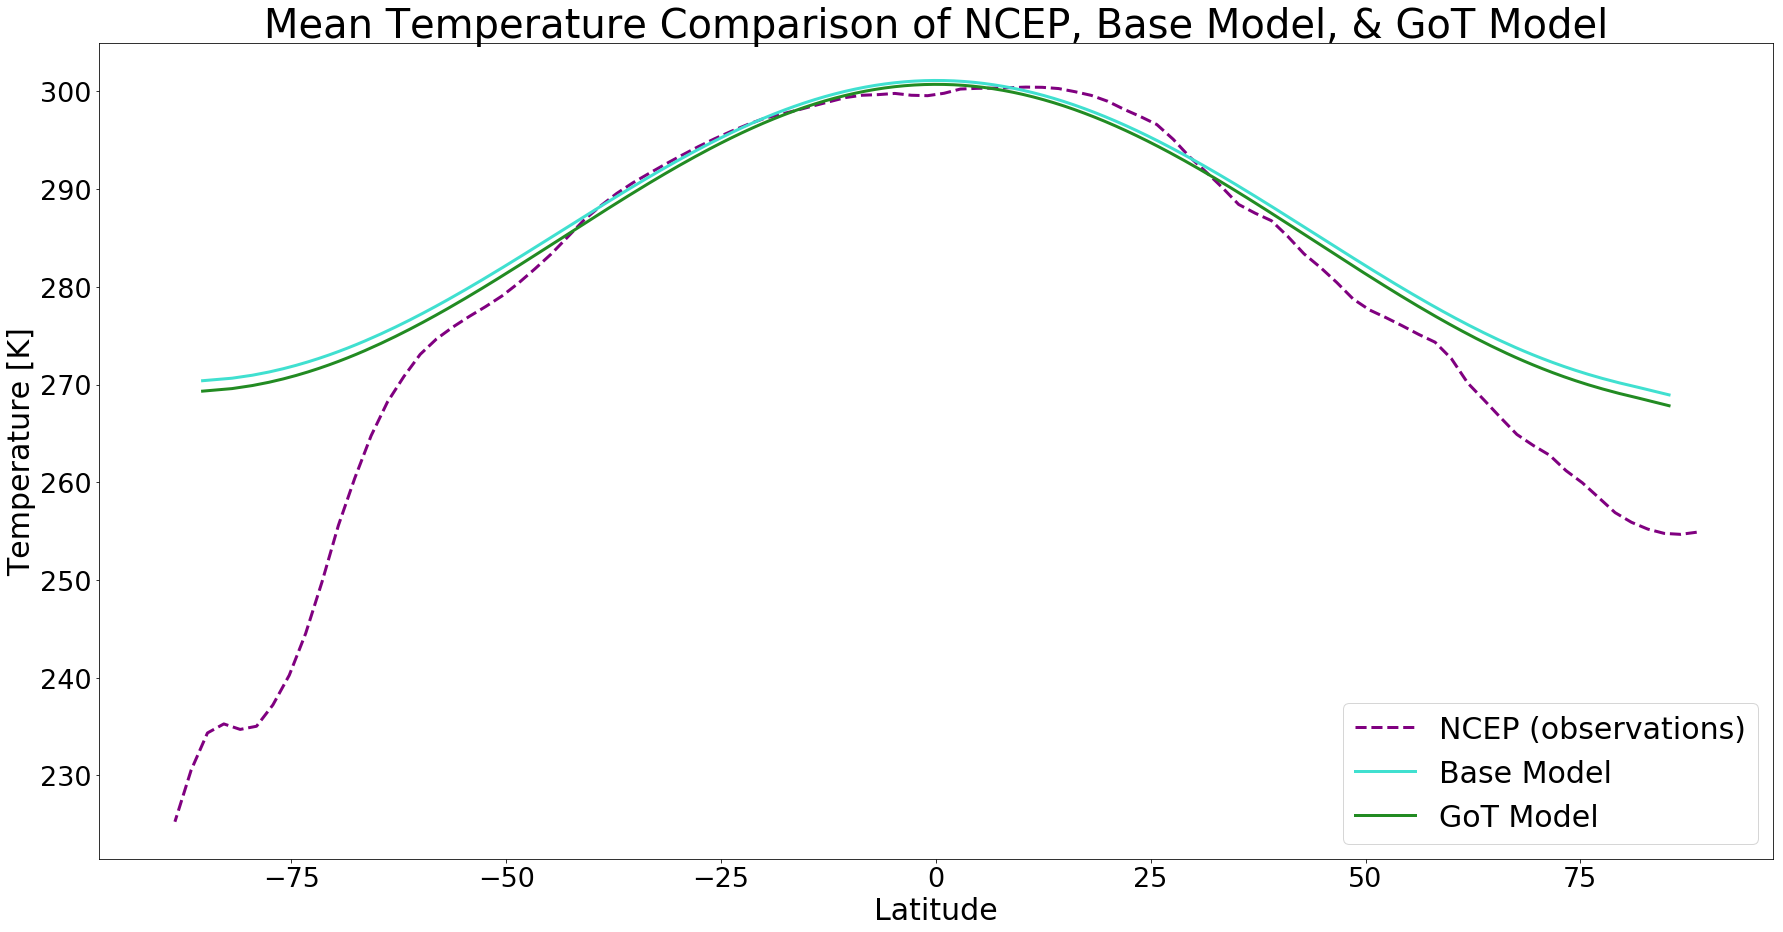

In [32]:
# Make plots. Start here for the observed temperatures from NCEP. 

fig = plt.figure(figsize=(30,15))
plt.plot(ncep_temp_zon.lat, ncep_temp_zon.mean(dim='time'), label='NCEP (observations)',linestyle='--',c='purple',linewidth=3.0)
plt.xlabel("Latitude",fontsize=30)
plt.ylabel("Temperature [K]",fontsize=30)
plt.title("Mean Temperature Comparison of NCEP, Base Model, & GoT Model",fontsize=40); 
ticks = [-90, -60, -30, 0, 30, 60, 90]
#ax.set_xticks(ticks);

# Base model mean line - 73 time steps (2 years)
plt.plot(model_lat, np.mean(T_lat_time_temp[:,-74:-1],axis=1),label='Base Model',c='turquoise',linewidth=3.0);

# GoT model mean line - 146 time steps (1 year)
plt.plot(model_lat, np.mean(T_lat_time_temp_GoT_rad_heat[:,-147:-1], axis=1),label='GoT Model',c='forestgreen',linewidth=3.0);

plt.yticks(fontsize=27)
plt.xticks(fontsize=27)
plt.legend(loc='lower right',fontsize=30)
plt.savefig('temp_comparison_NCEP_base_got.png')
plt.show()